## Numerical Solution of LWR model:

Lighthill-Whitham-Richards model (commonly used for traffic flow):

\begin{equation}
\frac{\partial q}{\partial x} + \frac{\partial k}{\partial t} = 0
\end{equation}

But $q$ is a function of $k$ (Greenshield model): 
$$
q(k) = k(k_j - k) = k k_j -k^2
$$

Therefore
$$
\frac{\partial k}{\partial t} + \frac{dq}{dk}\frac{\partial k}{\partial x} =0
$$

$$
\frac{d(q(k))}{dk} = 1(k_j - k) + k(-1) = k_j - 2k
$$

And
$$
\frac{\partial k}{\partial t} + (k_j - 2k) \frac{\partial k}{\partial x} = 0
$$

$$
\frac{\partial k}{\partial t} = (2k - k_j) \frac{\partial k}{\partial x}
$$

\begin{equation}
\frac{k(t+\Delta t, x_n) - k(t, x_n)}{\Delta t} =  \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{equation}

\begin{align}
k(t + \Delta t, x_n) =& k(t, x) + \Delta t \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{align}

\begin{align}
\frac{\partial{k}}{\partial x} \approx \frac{k(t, x + \Delta x) - k(t,x - \Delta x)}{2 \Delta x} \\
                               \approx \frac{k(t, x + \Delta x) - k(t, x)}{\Delta x} \\
\end{align}

If I remember correctly the central difference formula is unstable when used with the forward time step, 
but I will check into this.

**Update:** Yes, that's correct.  See Gaddam *et al.*., 2015.  Only the upwind scheme is stable, downwind and central are unstable.  Alternative leapfrog 
or higher order methods are mentioned in this reference.

Discretizing along t_i for i=0,$n_t$ and x_n for n=0, $n_x$.
$k_n^i$ equals the traffic density at time $t_i$ and position $n_i$.

Sampling rates are $\Delta t$ and $\Delta x$, respectively.
$k_j(x)$ is location dependent.  Call it $\kappa_n$.

$$
k_n^{i+1} = k_n^i + \Delta t  (2 k_n^i - \kappa_n) \frac{k_{n+1}^i - k_n^i}{\Delta x}
$$

In a real world scenario, we wouldn't have data at every point along the discretized distance.
This is different from the scenario tested here.  Therefore, the functions needs to be modified
to internally calculate points with the discretization distance needed to fulfill the stability criterion, while outputting predictions only where data is available.

In [1]:
import numpy as np

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets

In [3]:
import torch 
import torch.nn as nn

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cpu")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cpu


In [5]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [6]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim = 360, embedding_dim = 512, hidden_dim = 512):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.linear = nn.Linear(input_dim, embedding_dim)
        self.lstm = nn.LSTMCell(embedding_dim, hidden_dim)

    def forward(self, x, hidden): 
        embedded = F.relu(self.linear(x))
        hidden = self.lstm(embedded, hidden)
        return hidden
    
class Decoder(nn.Module):
    def __init__(self, embedding_dim = 512, hidden_dim = 512, output_dim = 360 - 3):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.linear1 = nn.Linear(output_dim, embedding_dim)
        self.lstm1 = nn.LSTMCell(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim - 3)

    def forward(self, x, hidden):
        embedded = F.relu(self.linear1(x))
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden 
    
class Seq2Seq(nn.Module): 
    def __init__(self, input_dim = 360, embedding_dim = 512, hidden_dim = 512, output_dim = 360):
        super(Seq2Seq, self).__init__()
        self.input_dim = input_dim
        self.encoder = Encoder(input_dim, embedding_dim, hidden_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, output_dim)
        
    def forward(self, x, boundary, output_length): 
#         print(x.shape)
        x = x.permute(0, 2, 1).float().to(device)  # (3, 120, 50)
        x = x.reshape(x.shape[0] * x.shape[1], -1) 
        x = x.unsqueeze(dim = 0)  # (1, 3*120, 50)

        decoder_outputs = torch.zeros((1, x.shape[1], output_length)).float().to(device) 
        
        h_0 = torch.zeros(1, self.encoder.hidden_dim).to(device)
        c_0 = torch.zeros(1, self.encoder.hidden_dim).to(device)
        encoder_hidden = (h_0,c_0)
        
        for ei in range(x.shape[2]):
            encoder_input = x[0, :, ei].unsqueeze(dim = 0)
            encoder_hidden = self.encoder(encoder_input, encoder_hidden) 
            
        decoder_input = encoder_input
        decoder_hidden = encoder_hidden
        
        for di in range(output_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
#             print(boundary[:, di].shape)
#             print(decoder_output.shape)
            decoder_output = torch.cat((boundary[:, di].unsqueeze(0), decoder_output), dim = 1) 
            decoder_outputs[:, :, di] = decoder_output
            decoder_input = decoder_output
        
        decoder_outputs = decoder_outputs.squeeze()
        outputs = decoder_outputs.reshape(3, 120, output_length) 
        outputs = outputs.permute(0, 2, 1)
        
        return outputs

In [106]:
## based on initial value
class FC(nn.Module): 
    def __init__(self, input_dim, seq_length, hidden_dim, output_dim): 
        super(FC, self).__init__()
        self.input_dim = input_dim 
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.fc = nn.Sequential(
            nn.Linear(input_dim * seq_length, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, output_dim) 
        )
    
    def forward(self, x, output_length): 
        x = x.permute(0, 2, 1).float().to(device)  ## 3, x, t
        x = x.reshape(x.shape[0] * x.shape[1] * x.shape[2]) 

        outputs = torch.zeros((360, output_length)).float().to(device) 
#         print(outputs.shape)
        for i in range(output_length): 
            out = self.fc(x)
            if self.seq_length != 1: 
                x = torch.cat((x[self.input_dim:], out), dim = 0)
            else: 
                x = out
            outputs[:, i] = out
            
        outputs = outputs.reshape(3, 120, output_length) 
        outputs = outputs.permute(0, 2, 1)
        return outputs

In [45]:
def loss_fn(output, target, weight, xi, ti): 
    output_mse = output[:, :, xi][:, ti, :]
    mse_loss = torch.mean((output_mse - target)**2) 
    
    dk_dt = (output[0, 1:, :] - output[0, :-1, :]) / 60
    dq_dx = (output[1, :, 1:] - output[1, :, :-1]) / 300
    dk_dt = torch.cat((torch.zeros(1, output.shape[2]), dk_dt), dim = 0) 
    dq_dx = torch.cat((torch.zeros(output.shape[1], 1), dq_dx), dim = 1)

    l2norm_loss = torch.linalg.norm(dq_dx + dk_dt) 
    
    loss = weight[0] * mse_loss + weight[1] * l2norm_loss
    return mse_loss

In [74]:
def loss_PDE(output): 
#     output_mse = output[:, :, xi][:, ti, :]
#     mse_loss = torch.mean((output_mse - target)**2) 
    
    dk_dt = (output[0, 1:, :] - output[0, :-1, :]) / 60
    dq_dx = (output[1, :, 1:] - output[1, :, :-1]) / 300
    dk_dt = torch.cat((torch.zeros(1, output.shape[2]), dk_dt), dim = 0) 
    dq_dx = torch.cat((torch.zeros(output.shape[1], 1), dq_dx), dim = 1)
    
    ## dq_dx + dk_dt = 0
    l2norm_loss = torch.linalg.norm(dq_dx + dk_dt) 
    
#     loss = weight[0] * mse_loss + weight[1] * l2norm_loss
    return l2norm_loss

## PINN 
PINN is not a good solution for this traffic forecasting problem. It requires data on every gridpoint along with additional input t and x in order to pass into the surrogate model.  
The time interval of PEMS data is 5 mins, and the space distance between sensors is different. Requires discretization and also data on each point, which doesnt exist by now. 

In [8]:
## Fully-connected network (initial value) + PDE cost function

# class PINN(nn.Module): 
#     def __init__(self, initial, boundary, input_dim, seq_length, hidden_dim, output_dim): 
#         super(PINN, self).__init__() 

#         self.initial = initial  # (3, 120)
#         self.boundary = boundary  # (3, 4550) 
#         self.seq_length = seq_length 
        
#         self.net1 = FC(input_dim, 1, hidden_dim, output_dim) 
# #         self.net2 = FC(input_dim, seq_length, hidden_dim * 2, output_dim)
    

#     def forward(self, output_length): 
#         # predict k, q, u in the next 5 mins (50 dt)
 
#         outputs = [] ## (3, nx, output_length) 
#         odeInput = self.initial.unsqueeze(dim = 1)
#         outputs.append(odeInput)
# #         initial_t = torch.zeros((odeInput.shape), requires_grad = True)
# #         initial_n = torch.zeros((odeInput.shape), requires_grad = True)
#         ## initial 5 min timestep 
#         output = self.net1(odeInput, 5 * output_length) 
#         outputs.append(output)
# #         outputs.append(output[:, -1, :]) 
        
#         ###
#         # Grad version: append t (120, 5) and n (120, 5) to the input and pass (120 * 5) into LSTM cell
#         # Approx version: none
#         ###
# #         all_grads = []
# #         ## compute grad 
# #         dk_dt = grad(outputs = output[0, :, :], inputs = t, grad_outputs=torch.ones_like(t), allow_unused=True) 
# #         dq_dx = grad(outputs = output[1, :, :], inputs = n, grad_outputs=torch.ones_like(t), allow_unused=True) 
# #         all_grads.append((dk_dt, dq_dx)) 
        
#         ## recurrent 5 min timesteps
# #         for i in range(0, output_length - 1): 
# # #             print(self.boundary[:, 50 * i:50 * i + 50].shape)
# # #             print(output.shape) 
# #             odeInput = output 
# #             odeInput[:, :, 0] = self.boundary[:, 5 * i + 1:5 * i + 6]
# #             output = self.net2(odeInput, 5) 
# #             outputs.append(output)

#         outputs = torch.cat(outputs, dim = 1) 
#         print(outputs.shape)
# #         outputs = outputs.permute(0, 2, 1)  # (3, output_length, nx)
        
#         return outputs   

In [53]:
## seq_to_seq (initial value) + PDE cost function

class PINN_RNN(nn.Module): 
    def __init__(self, nx, dx, dt, input_dim, embedding_dim, hidden_dim, output_dim): 
        super(PINN_RNN, self).__init__() 
        self.nx = nx 
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
#         self.initial = initial  # (3, 120)
#         self.boundary = boundary  # (3, 4550)
        
        self.net = Seq2Seq(input_dim, embedding_dim, hidden_dim, output_dim) 
    

    def forward(self, initial, boundary, output_length): 
        # predict k, q, u in the next 5 mins (50 dt)
#         outputs_all = []  ## (3, nx, output_length)  
        outputs = [] ## (3, nx, output_length) 
        odeInput = initial.unsqueeze(dim = 1)
        outputs.append(odeInput)
#         initial_t = torch.zeros((odeInput.shape), requires_grad = True)
#         initial_n = torch.zeros((odeInput.shape), requires_grad = True)
        ## initial 5 min timestep 
        output = self.net(odeInput, boundary[:, 0:5], 5)
        outputs.append(output)
#         outputs.append(output[:, -1, :]) 
        
        ###
        # Grad version: append t (120, 50) and n (120, 50) to the input and pass (120 * 5) into LSTM cell
        # Approx version: none
        ###
#         all_grads = []
#         ## compute grad 
#         dk_dt = grad(outputs = output[0, :, :], inputs = t, grad_outputs=torch.ones_like(t), allow_unused=True) 
#         dq_dx = grad(outputs = output[1, :, :], inputs = n, grad_outputs=torch.ones_like(t), allow_unused=True) 
#         all_grads.append((dk_dt, dq_dx)) 
        
        ## recurrent 5 min timesteps
        for i in range(1, output_length): 
            odeInput = output 
#             odeInput = torch.cat((self.boundary[:, 50 * i:50 * i + 50], output), dim = 1) 
            output = self.net(odeInput, boundary[:, 5 * i:5 * i + 5], 5) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim = 1) 
        print(outputs.shape)
#         outputs = outputs.permute(0, 2, 1)  # (3, output_length, nx)
        
        return outputs    

In [15]:
## to calculate gradient wrt. t and x (expand input dimension to 5 x nt x nx)

n = np.linspace(0, (120 - 1) * 300, 120)
_, nn = np.meshgrid(np.zeros(50), n)
nn

array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [  300.,   300.,   300., ...,   300.,   300.,   300.],
       [  600.,   600.,   600., ...,   600.,   600.,   600.],
       ...,
       [35100., 35100., 35100., ..., 35100., 35100., 35100.],
       [35400., 35400., 35400., ..., 35400., 35400., 35400.],
       [35700., 35700., 35700., ..., 35700., 35700., 35700.]])

In [9]:
y_exact=torch.load("5S_191111_3cmp_torch.pt").to(device)
#first row (0) k, then (1) q, then (2) u
#y_exact=y_exact[0:5,:]
print(y_exact.shape)

torch.Size([3, 71, 31])


In [10]:
y_exact[2, :, :].mean() 

tensor(29.1056, dtype=torch.float64)

In [11]:
y_exact[0,:,:].mean().mean()

tensor(0.0456, dtype=torch.float64)

In [12]:
#maximum observed velocity.  Indication for characteristic velocity $v_f$.
y_exact[2,:,:].max()

tensor(32.9916, dtype=torch.float64)

In [13]:
#maximum observed density.  Jam density $k_j$ can not be lower than this!
y_exact[0,:,:].max()

tensor(0.0995, dtype=torch.float64)

### Normalization 

In [14]:
# min-max normalization for k and u 
# to_transform()
y_min = torch.tensor([y_exact[0, :, :].min(), y_exact[1, :, :].min(), y_exact[2, :, :].min()])
y_max = torch.tensor([y_exact[0, :, :].max(), y_exact[1, :, :].max(), y_exact[2, :, :].max()])
y_norm = torch.zeros(y_exact.shape, dtype = torch.double)
y_norm[0, :, :] = (y_exact[0, :, :] - y_min[0]) / (y_max[0] - y_min[0]) 
y_norm[1, :, :] = (y_exact[1, :, :] - y_min[1]) / (y_max[1] - y_min[1]) 
# y_norm[1, :, :] = y_exact[1, :, :] 
y_norm[2, :, :] = (y_exact[2, :, :] - y_min[2]) / (y_max[2] - y_min[2]) 

In [14]:
y_min[0]

tensor(0.0069, dtype=torch.float64)

In [15]:
y_min[1]

tensor(0.2100, dtype=torch.float64)

In [15]:
import numpy as np
#nx=350  # 
nx=120
#kj needs to be larger than k for the solution to be stable 
kj = np.ones((nx,), dtype=float) * 0.2
kj = (kj - y_min[0].numpy()) / (y_max[0].numpy() - y_min[0].numpy()) # normalize

#characteristic velocity (m/s), corresponds to roughly 120 km/h
vf = np.ones((nx,), dtype=float) * 33
vf = (vf - y_min[2].numpy()) / (y_max[2].numpy() - y_min[2].numpy()) # normalize

dx=300.
dt=6.
#need an output every 5 mins (300 s), so tskip = 3 with dt = 3s
tskip=50
#nt=int(3600*6/6 - 50)
#nt=7099 #6 hours (times 3600 s/hour divided by dt=3s)
nto=(y_exact.shape[1]+1) 
#nt=int(3600*nto/12/6/dt - tskip)
dtobs=300
nt=int((dtobs*nto)/dt - tskip)
print(dt,nt)

#assert int(nt/tskip) == nto

6.0 3550


In [11]:
#import pandas as pd
import json

station_pos_idx=json.load(open("5S_station_pos_idx_dx=%04dm.json" % int(dx), "rb"))
#station_pos_idx=pd.read_json("station_pos_idx.json")
xi=list(station_pos_idx.values())

xi0=xi[0]
for p in range(len(xi)):
    xi[p] = xi[p] - xi0

#shift xi's such that model starts at first receiver
#(because observed data at this receiver is input at upstream model end)
print(xi)
#xi=xi-xi[0]
#xi

FileNotFoundError: [Errno 2] No such file or directory: '5S_station_pos_idx_dx=0300m.json'

In [16]:
xi = [0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]

The exact solution is provided in cars / km.  However, I changed the units from km and hours to meters and seconds.  Therefore, the density should be divided by 1000.

**Update:** Not needed, `avg_occupancy` is already given in cars/meters (check this.  They might be using miles).

Defining the initial values of the traffic density in the model.  They need to be defined on every point on the computational grid, not just at those positions where there is data.  I am interpolating them between the sensors, and extrapolating using initial values on the end sensors.

In [17]:
from scipy.interpolate import interp1d
print(xi)
def interpolate_initial(var, t0=0):
    IM=interp1d(np.array(xi)*dx, var[t0,:].numpy(), bounds_error=False, 
                fill_value=(var[t0,0], var[t0,-1]), kind='linear')
    
    x=np.linspace(0, (nx-1)*dx, nx)
    return IM(x)

[0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]


In [18]:
k_initial={}
cmps = ["k","q","u"]
for n,c in enumerate(cmps):
    k_initial[c]=interpolate_initial(y_norm[n,:])
    print(k_initial[c].max())

0.7202583590443943
0.8105095541401275
0.9269662921348317


In [20]:
np.linspace(0, (50-1)*dt, 50)

array([  0.,   6.,  12.,  18.,  24.,  30.,  36.,  42.,  48.,  54.,  60.,
        66.,  72.,  78.,  84.,  90.,  96., 102., 108., 114., 120., 126.,
       132., 138., 144., 150., 156., 162., 168., 174., 180., 186., 192.,
       198., 204., 210., 216., 222., 228., 234., 240., 246., 252., 258.,
       264., 270., 276., 282., 288., 294.])

The boundary condition at the upstream end also need to be interpolated:

71 3
(3550,) 0.43213868956724444
(3550,) 0.6114649681528663
(3550,) 0.9859550561797752


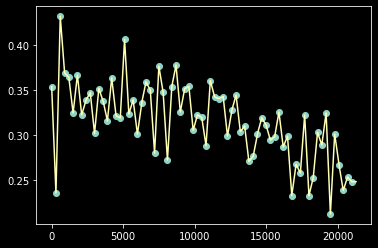

In [19]:
ti=np.arange(0, (nt-1)*dt, tskip*dt )
print(len(ti), y_norm.shape[0])
t=np.linspace(0, (nt-1)*dt, nt)
#print(len(ti), len(y_exact))
#print(t)

k_boundary={}

for n,c in enumerate(cmps):
    IMb=interp1d(np.array(ti), y_norm[n,:,0].numpy(), bounds_error=False,
             fill_value=(y_norm[n,0,0], y_norm[n,-1,0]),
             kind='linear')
    k_boundary[c]=IMb(t)
    print(k_boundary[c].shape, k_boundary[c].max())

fig2,ax2=plt.subplots()
ax2.plot(ti, y_norm[0,:,0], marker='o', linewidth=0)
ax2.plot(t, k_boundary["k"])

In [24]:
initial = torch.tensor(np.stack((k_initial["k"], k_initial["q"], k_initial["u"]))).float().to(device)
boundary = torch.tensor(np.stack((k_boundary["k"][::10], k_boundary["q"][::10], k_boundary["u"][::10]))).float().to(device)

In [123]:
boundary.shape

torch.Size([3, 355])

In [55]:
input_dim = 360 
embedding_dim = 512
hidden_dim = 512
output_dim = 360

pinn = PINN_RNN(nx, dx, dt, input_dim, embedding_dim, hidden_dim, output_dim).to(device) 

# pinn = PINN(initial, boundary, input_dim, seq_length, hidden_dim, output_dim).to(device)

In [153]:
#torch.optim.lr_scheduler.StepLR?
#torch.optim.SGD?

In [56]:
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(tdnu.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.95) #0.95 #step_size=1
#torch.optim.lr_scheduler.StepLR?

- reduce time step $\Delta t$
- try different optimizer
- reduce learning rate decay (step_size in scheduler) - 500 epochs

In [38]:
num_epochs = 100
loss_fun = torch.nn.MSELoss()
weight = [0.3, 0.7]
min_loss = 10

In [42]:
xi = [0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]

In [43]:
ti = np.arange(0, 3400, 50)

In [32]:
ti = ti / 60

In [33]:
ti

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345., 350.])

In [57]:
y_approx = pinn(initial, boundary, 68)
print(y_exact[:, 0:68].shape, y_approx.shape)

torch.Size([3, 341, 120])
torch.Size([3, 68, 31]) torch.Size([3, 341, 120])


In [46]:
y_norm = y_norm.to(device)

In [58]:
loss_fn(y_approx, y_norm[:, 0:68], weight, xi, ti[0:68])
# loss_PDE(y_approx)

tensor(0.3592, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [116]:
loss_mse = torch.nn.MSELoss()

In [36]:
print(y_approx[:, :, xi][:, ti[0:68], :].shape, y_norm.shape)
loss=loss_fn(y_approx, y_norm[:,0:68,:], weight, xi, ti[0:68])
#torch.cat(tdn.k, dim=1).shape
#torch.cat([torch.tensor(p) for p in tdn.k], dim=1).shape 
# loss = loss_mse(y_approx[:, :, xi][:, ti[0:68], :], y_norm[:,0:68,:])
print("Initial loss: %e" % loss)
loss_history=[loss.item()]

torch.Size([3, 68, 31]) torch.Size([3, 71, 31])
Initial loss: 3.628894e-01


In [103]:
3.442055e-01

0.3442055

In [104]:
## loss without normalization 
y_approx_actual = torch.zeros(y_approx[:, :, xi][:, ti[0:68], :].shape) 
y_approx_actual[0, :, :] = y_approx[:, :, xi][:, ti[0:68], :][0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[:, :, xi][:, ti[0:68], :][1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_approx_actual[2, :, :] = y_approx[:, :, xi][:, ti[0:68], :][2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

# loss=loss_fun(y_approx_actual, y_exact[:,0:68,:]) 
# print("Initial actual loss: %e" % loss) 
loss_mse(y_approx_actual, y_exact[:,0:68,:])

tensor(46.6895, dtype=torch.float64, grad_fn=<MseLossBackward>)

In [59]:
history=[]
tqdm_epochs = tqdm(range(num_epochs))
for e in tqdm_epochs:
    y_approx = pinn(initial, boundary, 68)
    loss = loss_fn(y_approx, y_norm[:,0:68,:], weight, xi, ti[0:68])
#     loss = loss_PDE(y_approx)
    loss_history.append(loss.item())
    if loss.item() < min_loss:
        best_model_pinn = pinn
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history.append(loss.item())
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()}) 
    
    scheduler.step() 

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([3, 341, 120])


  1%|          | 1/100 [00:02<04:54,  2.98s/it, loss=0.359]

torch.Size([3, 341, 120])


  2%|▏         | 2/100 [00:05<04:40,  2.86s/it, loss=4.08] 

torch.Size([3, 341, 120])


  3%|▎         | 3/100 [00:08<04:30,  2.79s/it, loss=1.65]

torch.Size([3, 341, 120])


  4%|▍         | 4/100 [00:11<04:24,  2.75s/it, loss=2.56]

torch.Size([3, 341, 120])


  5%|▌         | 5/100 [00:13<04:19,  2.74s/it, loss=0.373]

torch.Size([3, 341, 120])


  6%|▌         | 6/100 [00:16<04:20,  2.77s/it, loss=0.241]

torch.Size([3, 341, 120])


  7%|▋         | 7/100 [00:19<04:23,  2.83s/it, loss=0.383]

torch.Size([3, 341, 120])


  8%|▊         | 8/100 [00:22<04:27,  2.91s/it, loss=0.414]

torch.Size([3, 341, 120])


  9%|▉         | 9/100 [00:25<04:31,  2.99s/it, loss=0.316]

torch.Size([3, 341, 120])


 10%|█         | 10/100 [00:28<04:31,  3.02s/it, loss=0.181]

torch.Size([3, 341, 120])


 11%|█         | 11/100 [00:32<04:29,  3.03s/it, loss=0.0968]

torch.Size([3, 341, 120])


 12%|█▏        | 12/100 [00:35<04:24,  3.01s/it, loss=0.0902]

torch.Size([3, 341, 120])


 13%|█▎        | 13/100 [00:37<04:17,  2.96s/it, loss=0.119] 

torch.Size([3, 341, 120])


 14%|█▍        | 14/100 [00:40<04:10,  2.92s/it, loss=0.146]

torch.Size([3, 341, 120])


 15%|█▌        | 15/100 [00:43<04:04,  2.88s/it, loss=0.145]

torch.Size([3, 341, 120])


 16%|█▌        | 16/100 [00:46<03:59,  2.85s/it, loss=0.116]

torch.Size([3, 341, 120])


 17%|█▋        | 17/100 [00:49<03:55,  2.84s/it, loss=0.0803]

torch.Size([3, 341, 120])


 18%|█▊        | 18/100 [00:51<03:50,  2.82s/it, loss=0.0563]

torch.Size([3, 341, 120])


 19%|█▉        | 19/100 [00:54<03:46,  2.80s/it, loss=0.0514]

torch.Size([3, 341, 120])


 20%|██        | 20/100 [00:57<03:42,  2.79s/it, loss=0.0594]

torch.Size([3, 341, 120])


 21%|██        | 21/100 [01:00<03:39,  2.78s/it, loss=0.0675]

torch.Size([3, 341, 120])


 22%|██▏       | 22/100 [01:02<03:35,  2.77s/it, loss=0.0646]

torch.Size([3, 341, 120])


 23%|██▎       | 23/100 [01:05<03:35,  2.79s/it, loss=0.0562]

torch.Size([3, 341, 120])


 24%|██▍       | 24/100 [01:08<03:32,  2.79s/it, loss=0.0443]

torch.Size([3, 341, 120])


 25%|██▌       | 25/100 [01:11<03:28,  2.78s/it, loss=0.0348]

torch.Size([3, 341, 120])


 26%|██▌       | 26/100 [01:13<03:24,  2.77s/it, loss=0.0308]

torch.Size([3, 341, 120])


 27%|██▋       | 27/100 [01:16<03:22,  2.77s/it, loss=0.0311]

torch.Size([3, 341, 120])


 28%|██▊       | 28/100 [01:19<03:19,  2.76s/it, loss=0.0323]

torch.Size([3, 341, 120])


 29%|██▉       | 29/100 [01:22<03:17,  2.78s/it, loss=0.0319]

torch.Size([3, 341, 120])


 30%|███       | 30/100 [01:25<03:14,  2.78s/it, loss=0.0294]

torch.Size([3, 341, 120])


 31%|███       | 31/100 [01:27<03:11,  2.78s/it, loss=0.0258]

torch.Size([3, 341, 120])


 32%|███▏      | 32/100 [01:30<03:08,  2.77s/it, loss=0.0225]

torch.Size([3, 341, 120])


 33%|███▎      | 33/100 [01:33<03:05,  2.76s/it, loss=0.0202]

torch.Size([3, 341, 120])


 34%|███▍      | 34/100 [01:36<03:02,  2.77s/it, loss=0.019] 

torch.Size([3, 341, 120])


 35%|███▌      | 35/100 [01:38<03:00,  2.78s/it, loss=0.0185]

torch.Size([3, 341, 120])


 36%|███▌      | 36/100 [01:41<02:57,  2.77s/it, loss=0.0181]

torch.Size([3, 341, 120])


 37%|███▋      | 37/100 [01:44<02:54,  2.77s/it, loss=0.0175]

torch.Size([3, 341, 120])


 38%|███▊      | 38/100 [01:47<02:51,  2.77s/it, loss=0.0164]

torch.Size([3, 341, 120])


 39%|███▉      | 39/100 [01:49<02:48,  2.76s/it, loss=0.0152]

torch.Size([3, 341, 120])


 40%|████      | 40/100 [01:52<02:46,  2.78s/it, loss=0.0141]

torch.Size([3, 341, 120])


 41%|████      | 41/100 [01:55<02:43,  2.77s/it, loss=0.0134]

torch.Size([3, 341, 120])


 42%|████▏     | 42/100 [01:58<02:40,  2.77s/it, loss=0.0128]

torch.Size([3, 341, 120])


 43%|████▎     | 43/100 [02:01<02:37,  2.76s/it, loss=0.0122]

torch.Size([3, 341, 120])


 44%|████▍     | 44/100 [02:03<02:34,  2.76s/it, loss=0.0118]

torch.Size([3, 341, 120])


 45%|████▌     | 45/100 [02:06<02:31,  2.76s/it, loss=0.0115]

torch.Size([3, 341, 120])


 46%|████▌     | 46/100 [02:09<02:29,  2.77s/it, loss=0.0113]

torch.Size([3, 341, 120])


 47%|████▋     | 47/100 [02:12<02:26,  2.76s/it, loss=0.0111]

torch.Size([3, 341, 120])


 48%|████▊     | 48/100 [02:14<02:23,  2.76s/it, loss=0.0106]

torch.Size([3, 341, 120])


 49%|████▉     | 49/100 [02:17<02:20,  2.75s/it, loss=0.00996]

torch.Size([3, 341, 120])


 50%|█████     | 50/100 [02:20<02:17,  2.76s/it, loss=0.0095] 

torch.Size([3, 341, 120])


 51%|█████     | 51/100 [02:23<02:15,  2.76s/it, loss=0.00937]

torch.Size([3, 341, 120])


 52%|█████▏    | 52/100 [02:26<02:14,  2.79s/it, loss=0.00942]

torch.Size([3, 341, 120])


 53%|█████▎    | 53/100 [02:28<02:10,  2.78s/it, loss=0.00942]

torch.Size([3, 341, 120])


 54%|█████▍    | 54/100 [02:31<02:07,  2.77s/it, loss=0.00923]

torch.Size([3, 341, 120])


 55%|█████▌    | 55/100 [02:34<02:04,  2.77s/it, loss=0.0089] 

torch.Size([3, 341, 120])


 56%|█████▌    | 56/100 [02:37<02:01,  2.76s/it, loss=0.00861]

torch.Size([3, 341, 120])


 57%|█████▋    | 57/100 [02:39<01:58,  2.75s/it, loss=0.00846]

torch.Size([3, 341, 120])


 58%|█████▊    | 58/100 [02:42<01:56,  2.78s/it, loss=0.00841]

torch.Size([3, 341, 120])


 59%|█████▉    | 59/100 [02:45<01:53,  2.77s/it, loss=0.00839]

torch.Size([3, 341, 120])


 60%|██████    | 60/100 [02:48<01:50,  2.76s/it, loss=0.00834]

torch.Size([3, 341, 120])


 61%|██████    | 61/100 [02:50<01:47,  2.76s/it, loss=0.00825]

torch.Size([3, 341, 120])


 62%|██████▏   | 62/100 [02:53<01:44,  2.76s/it, loss=0.00815]

torch.Size([3, 341, 120])


 63%|██████▎   | 63/100 [02:56<01:42,  2.77s/it, loss=0.00806]

torch.Size([3, 341, 120])


 64%|██████▍   | 64/100 [02:59<01:40,  2.78s/it, loss=0.00798]

torch.Size([3, 341, 120])


 65%|██████▌   | 65/100 [03:01<01:37,  2.78s/it, loss=0.00792]

torch.Size([3, 341, 120])


 66%|██████▌   | 66/100 [03:04<01:34,  2.78s/it, loss=0.00788]

torch.Size([3, 341, 120])


 67%|██████▋   | 67/100 [03:07<01:31,  2.79s/it, loss=0.00785]

torch.Size([3, 341, 120])


 68%|██████▊   | 68/100 [03:10<01:28,  2.77s/it, loss=0.00782]

torch.Size([3, 341, 120])


 69%|██████▉   | 69/100 [03:13<01:26,  2.78s/it, loss=0.00779]

torch.Size([3, 341, 120])


 70%|███████   | 70/100 [03:15<01:23,  2.77s/it, loss=0.00776]

torch.Size([3, 341, 120])


 71%|███████   | 71/100 [03:18<01:20,  2.77s/it, loss=0.00772]

torch.Size([3, 341, 120])


 72%|███████▏  | 72/100 [03:21<01:17,  2.76s/it, loss=0.00768]

torch.Size([3, 341, 120])


 73%|███████▎  | 73/100 [03:24<01:14,  2.76s/it, loss=0.00765]

torch.Size([3, 341, 120])


 74%|███████▍  | 74/100 [03:26<01:11,  2.76s/it, loss=0.00763]

torch.Size([3, 341, 120])


 75%|███████▌  | 75/100 [03:29<01:09,  2.78s/it, loss=0.00762]

torch.Size([3, 341, 120])


 76%|███████▌  | 76/100 [03:32<01:06,  2.77s/it, loss=0.00762]

torch.Size([3, 341, 120])


 77%|███████▋  | 77/100 [03:35<01:03,  2.76s/it, loss=0.0076] 

torch.Size([3, 341, 120])


 78%|███████▊  | 78/100 [03:37<01:00,  2.76s/it, loss=0.00758]

torch.Size([3, 341, 120])


 79%|███████▉  | 79/100 [03:40<00:57,  2.75s/it, loss=0.00756]

torch.Size([3, 341, 120])


 80%|████████  | 80/100 [03:43<00:55,  2.75s/it, loss=0.00754]

torch.Size([3, 341, 120])


 81%|████████  | 81/100 [03:46<00:52,  2.77s/it, loss=0.00754]

torch.Size([3, 341, 120])


 82%|████████▏ | 82/100 [03:49<00:49,  2.77s/it, loss=0.00753]

torch.Size([3, 341, 120])


 83%|████████▎ | 83/100 [03:51<00:46,  2.76s/it, loss=0.00753]

torch.Size([3, 341, 120])


 84%|████████▍ | 84/100 [03:54<00:44,  2.76s/it, loss=0.00752]

torch.Size([3, 341, 120])


 85%|████████▌ | 85/100 [03:57<00:41,  2.76s/it, loss=0.00751]

torch.Size([3, 341, 120])


 86%|████████▌ | 86/100 [04:00<00:38,  2.77s/it, loss=0.0075] 

torch.Size([3, 341, 120])


 87%|████████▋ | 87/100 [04:03<00:37,  2.87s/it, loss=0.0075]

torch.Size([3, 341, 120])


 88%|████████▊ | 88/100 [04:06<00:34,  2.90s/it, loss=0.00749]

torch.Size([3, 341, 120])


 89%|████████▉ | 89/100 [04:08<00:31,  2.85s/it, loss=0.00748]

torch.Size([3, 341, 120])


 90%|█████████ | 90/100 [04:11<00:28,  2.83s/it, loss=0.00748]

torch.Size([3, 341, 120])


 91%|█████████ | 91/100 [04:14<00:25,  2.81s/it, loss=0.00748]

torch.Size([3, 341, 120])


 92%|█████████▏| 92/100 [04:17<00:22,  2.82s/it, loss=0.00747]

torch.Size([3, 341, 120])


 93%|█████████▎| 93/100 [04:20<00:19,  2.80s/it, loss=0.00747]

torch.Size([3, 341, 120])


 94%|█████████▍| 94/100 [04:22<00:16,  2.79s/it, loss=0.00747]

torch.Size([3, 341, 120])


 95%|█████████▌| 95/100 [04:25<00:13,  2.80s/it, loss=0.00747]

torch.Size([3, 341, 120])


 96%|█████████▌| 96/100 [04:28<00:11,  2.83s/it, loss=0.00746]

torch.Size([3, 341, 120])


 97%|█████████▋| 97/100 [04:31<00:08,  2.89s/it, loss=0.00746]

torch.Size([3, 341, 120])


 98%|█████████▊| 98/100 [04:34<00:05,  2.93s/it, loss=0.00746]

torch.Size([3, 341, 120])


 99%|█████████▉| 99/100 [04:37<00:02,  2.93s/it, loss=0.00746]

torch.Size([3, 341, 120])


100%|██████████| 100/100 [04:40<00:00,  2.80s/it, loss=0.00746]


In [60]:
## re-transform: loss without normalization 
y_approx_actual = torch.zeros(y_approx[:, :, xi][:, ti[0:68], :].shape) 
y_approx_actual[0, :, :] = y_approx[:, :, xi][:, ti[0:68], :][0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_approx_actual[1, :, :] = y_approx[:, :, xi][:, ti[0:68], :][1, :, :] * (y_max[1] - y_min[1]) + y_min[1]
y_approx_actual[2, :, :] = y_approx[:, :, xi][:, ti[0:68], :][2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_approx_actual, y_exact[:,0:68,:]) 
print("Final actual loss: %e" % loss) 

Final actual loss: 5.004970e-01


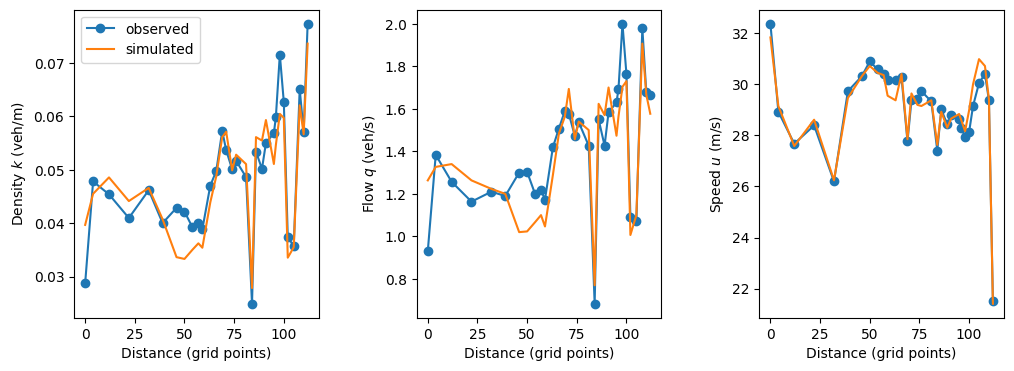

In [61]:
tp=1
#print(y_approx[tp])
#print(y_exact[tp])
plt.style.use('default')
fig3,ax3=plt.subplots(ncols=3, nrows=1, figsize=(12,4))
fig3.subplots_adjust(wspace=0.4)

varplot={0: y_approx_actual[0, :, :], 1: y_approx_actual[1, :, :], 2: y_approx_actual[2, :, :]}
label={0: "Density $k$ (veh/m)",
       1: "Flow $q$ (veh/s)",
       2: "Speed $u$ (m/s)"}
for n in range(3):
    ax3[n].plot(xi, y_exact[n,1,:].detach(), label='observed', marker='o')
    if n==1: 
        ax3[n].plot(xi, varplot[n][0].detach(), label='simulated') 
    else: 
        ax3[n].plot(xi, varplot[n][0].detach(), label='simulated')
    #print(k_boundary[tp*tskip])
    if n==0:
        ax3[n].legend()
    ax3[n].set_xlabel("Distance (grid points)")
    ax3[n].set_ylabel(label[n])
#ax3.set_ylim(0, 0.3)
fig3.savefig("kqu_parstep10.png", dpi=300)

In [62]:
k_initial2={}
cmps = ["k","q","u"]
for n,c in enumerate(cmps):
    k_initial2[c]=interpolate_initial(y_norm[n,:], t0=68)
    print(k_initial2[c].max())

0.4849234516620852
0.6321656050955415
0.9578651685393261


In [75]:
# k_boundary2 = {var: k_boundary[var][68*tskip:] for var in k_boundary.keys()}

In [63]:
initial2 = torch.tensor(np.stack((k_initial2["k"], k_initial2["q"], k_initial2["u"]))).float().to(device)
# boundary2 = torch.tensor(np.stack((k_boundary2["k"], k_boundary2["q"], k_boundary2["u"]))).float().to(device)

In [85]:
## prediction 
y_predicted = pinn(initial2, boundary[:, 340:], 3)

torch.Size([3, 16, 120])


In [86]:
## re-transform: testing loss without normalization (used for comparison)
y_predicted_actual = torch.zeros(y_predicted[:, :, xi][:, ti[0:3], :].shape) 
y_predicted_actual[0, :, :] = y_predicted[:, :, xi][:, ti[0:3], :][0, :, :] * (y_max[0] - y_min[0]) + y_min[0]
y_predicted_actual[1, :, :] = y_predicted[:, :, xi][:, ti[0:3], :][1, :, :]
y_predicted_actual[2, :, :] = y_predicted[:, :, xi][:, ti[0:3], :][2, :, :] * (y_max[2] - y_min[2]) + y_min[2] 

loss=loss_fun(y_predicted_actual, y_exact[:, 68:, :]) 
print("Final actual loss: %e" % loss) 

Final actual loss: 4.962298e-01


In [70]:
4.962298e-01

0.4962298

In [71]:
y_predicted.shape

torch.Size([3, 16, 120])

In [87]:
y_predicted = y_predicted[:, :, xi][:, ti[0:3], :]

In [91]:
station_names=list(json.load(open("5S_station_names.json", "rb")).values())
record_times=json.load(open("5S_record_times.json", "r"))
#record_times

FileNotFoundError: [Errno 2] No such file or directory: '5S_station_names.json'

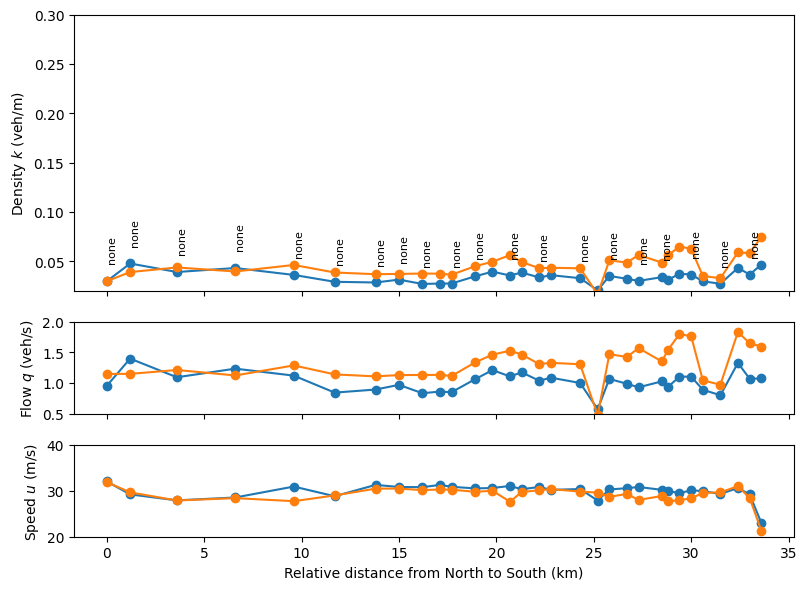

In [88]:
tp=70
plt.style.use('default')

from matplotlib import gridspec

fwyp=[xi[n]* 300 / 1.e3 for n in range(len(xi))]

#gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1]) 
gs_kw={"height_ratios": [3, 1, 1]}

fig4,ax4=plt.subplots(figsize=(8,6), nrows=3, gridspec_kw=gs_kw, sharex=True)
fig4.subplots_adjust(left=0.08, bottom=0.08, right=0.98, top=0.95)
ymin=[0.02, 0.5, 20]
ymax=[0.30, 2.0, 40]

for n in range(3): 
    ax4[n].plot(fwyp, (y_norm[n, tp, :] * (y_max[n] - y_min[n]) + y_min[n]).cpu().detach(), label='observed', marker='o')
    ax4[n].plot(fwyp, (y_predicted[n, tp-68, :] * (y_max[n] - y_min[n]) + y_min[n]).cpu().detach(), label='predicted', marker='o')
        
    ax4[n].set_ylim(ymin[n], ymax[n])
    #ax4[n].set_xlabel("Distance (grid points)")
    ax4[n].set_ylabel(label[n])

    #ax4[n].set_xlim(fwyp[0]-1, fwyp[-1]+1)

    lastpoint=-100
    if n==0:
        for p in range(len(xi)):
            if (fwyp[p] - lastpoint) > 1.:
                ax4[n].text(fwyp[p], (y_norm[n, tp, :] * (y_max[n] - y_min[n]) + y_min[n]).detach()[p] + 0.02, "none", rotation=90, fontsize=8)
                lastpoint=fwyp[p]
    
ax4[2].set_xlabel("Relative distance from North to South (km)")
#ax4[n].set_ylabel("Traffic density (Veh/m)")
fig4.savefig('LWR_prediction_5S.jpg', dpi=300)